<a href="https://colab.research.google.com/github/ConstantinVictorBeatErtel/energypricer/blob/main/energy_efficiency_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

This data analysis aims to find trends in energy consumption and forecast energy usaga. Additionally, I aim to see whether costs are highest at the right time. After that, I want to use the forecast to create an alert when energy usage is higher than typically at a certain hoursince this might be an indicator that energy might be wasted.

In [2]:
#Import Data
third_party_energy_consumption = pd.read_csv("https://raw.githubusercontent.com/ConstantinVictorBeatErtel/energyconsumption/477143f16032fbd9129b0c7fb8b9d5f261a205e1/D202.csv")

In [3]:
#Import Data
personal_usage_kwh = pd.read_csv("https://raw.githubusercontent.com/ConstantinVictorBeatErtel/energyconsumption/main/pge_electric_interval_data_7838257581_2024-01-01_to_2024-04-16.csv")
pge_q4_23 = pd.read_csv("https://raw.githubusercontent.com/ConstantinVictorBeatErtel/energyconsumption/main/PGE_2023_Q4_ElectricUsageByZip.csv")
pge_q1_24 = pd.read_csv("https://raw.githubusercontent.com/ConstantinVictorBeatErtel/energyconsumption/main/PGE_2024_Q1_ElectricUsageByZip.csv")
pge_2014 = pd.read_csv("https://raw.githubusercontent.com/ConstantinVictorBeatErtel/energyconsumption/main/pge_electric_interval_data_7838257581_2024-01-01_to_2024-04-16.csv")
weather_2014 = pd.read_csv("https://raw.githubusercontent.com/ConstantinVictorBeatErtel/energyconsumption/main/weather.csv")

In [4]:
#Data Exploration and Cleaning
#Inspecting the csv
third_party_energy_consumption

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN
...,...,...,...,...,...,...,...,...
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN


In [5]:
personal_usage_kwh

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,2024-01-01,00:00,00:59,0.09,kWh,$0.04,NaN
1,Electric usage,2024-01-01,01:00,01:59,0.11,kWh,$0.05,NaN
2,Electric usage,2024-01-01,02:00,02:59,0.12,kWh,$0.05,NaN
3,Electric usage,2024-01-01,03:00,03:59,0.07,kWh,$0.03,NaN
4,Electric usage,2024-01-01,04:00,04:59,0.09,kWh,$0.04,NaN
...,...,...,...,...,...,...,...,...
2561,Electric usage,2024-04-16,18:00,18:59,0.34,kWh,$0.14,NaN
2562,Electric usage,2024-04-16,19:00,19:59,0.21,kWh,$0.09,NaN
2563,Electric usage,2024-04-16,20:00,20:59,0.17,kWh,$0.07,NaN
2564,Electric usage,2024-04-16,21:00,21:59,0.31,kWh,$0.13,NaN


In [6]:
pge_q4_23

,ZIPCODE,MONTH,YEAR,CUSTOMERCLASS,COMBINED,TOTALCUSTOMERS,TOTALKWH,AVERAGEKWH
0,93101,10,2023,Elec- Agricultural,Y,0,0,NaN
1,93101,11,2023,Elec- Agricultural,Y,0,0,NaN
2,93101,12,2023,Elec- Agricultural,Y,0,0,NaN
3,93110,10,2023,Elec- Agricultural,Y,0,0,NaN
4,93110,11,2023,Elec- Agricultural,Y,0,0,NaN
...,...,...,...,...,...,...,...,...
7496,96137,11,2023,Elec- Residential,N,"2,797","941,144",336
7497,96137,12,2023,Elec- Residential,N,"2,802","1,002,953",358
7498,96162,10,2023,Elec- Residential,Y,0,0,NaN
7499,96162,11,2023,Elec- Residential,Y,0,0,NaN


In [7]:
#Data Preparation
#Checking for null values
for col in personal_usage_kwh.columns:
    null_count = personal_usage_kwh[col].isnull().sum()
    print(col)
    print(null_count)
for col in third_party_energy_consumption.columns:
    null_count = third_party_energy_consumption[col].isnull().sum()
    print(col)
    print(null_count)
for col in pge_q4_23.columns:
    null_count = pge_q4_23[col].isnull().sum()
    print(col)
    print(null_count)
for col in pge_q1_24.columns:
    null_count = pge_q1_24[col].isnull().sum()
    print(col)
    print(null_count)


TYPE
0
DATE
0
START TIME
0
END TIME
0
USAGE
0
UNITS
0
COST
0
NOTES
2566
TYPE
0
DATE
0
START TIME
0
END TIME
0
USAGE
0
UNITS
0
COST
0
NOTES
70368
ZIPCODE
0
MONTH
0
YEAR
0
CUSTOMERCLASS
0
COMBINED
0
TOTALCUSTOMERS
0
TOTALKWH
0
AVERAGEKWH
4390
ZIPCODE
0
MONTH
0
YEAR
0
CUSTOMERCLASS
0
COMBINED
0
TOTALCUSTOMERS
0
TOTALKWH
0
AVERAGEKWH
4399


In [8]:
#Creating a datetime
third_party_energy_consumption["datetime"] = third_party_energy_consumption["DATE"] + " " + third_party_energy_consumption["START TIME"]
third_party_energy_consumption["datetime"] = pd.to_datetime(third_party_energy_consumption["datetime"])
third_party_energy_consumption

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,datetime
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN,2016-10-22 00:00:00
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN,2016-10-22 00:15:00
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN,2016-10-22 00:30:00
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN,2016-10-22 00:45:00
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN,2016-10-22 01:00:00
...,...,...,...,...,...,...,...,...,...
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN,2018-10-24 22:45:00
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN,2018-10-24 23:00:00
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN,2018-10-24 23:15:00
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN,2018-10-24 23:30:00


In [9]:
#Turning personal usage into a datetime format
personal_usage_kwh["datetime"] = personal_usage_kwh["DATE"] + " " + personal_usage_kwh["START TIME"]
personal_usage_kwh["datetime"] = pd.to_datetime(personal_usage_kwh["datetime"])
personal_usage_kwh

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,datetime
0,Electric usage,2024-01-01,00:00,00:59,0.09,kWh,$0.04,NaN,2024-01-01 00:00:00
1,Electric usage,2024-01-01,01:00,01:59,0.11,kWh,$0.05,NaN,2024-01-01 01:00:00
2,Electric usage,2024-01-01,02:00,02:59,0.12,kWh,$0.05,NaN,2024-01-01 02:00:00
3,Electric usage,2024-01-01,03:00,03:59,0.07,kWh,$0.03,NaN,2024-01-01 03:00:00
4,Electric usage,2024-01-01,04:00,04:59,0.09,kWh,$0.04,NaN,2024-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...
2561,Electric usage,2024-04-16,18:00,18:59,0.34,kWh,$0.14,NaN,2024-04-16 18:00:00
2562,Electric usage,2024-04-16,19:00,19:59,0.21,kWh,$0.09,NaN,2024-04-16 19:00:00
2563,Electric usage,2024-04-16,20:00,20:59,0.17,kWh,$0.07,NaN,2024-04-16 20:00:00
2564,Electric usage,2024-04-16,21:00,21:59,0.31,kWh,$0.13,NaN,2024-04-16 21:00:00


In [10]:
#Set index
third_party_energy_consumption = third_party_energy_consumption.set_index("datetime")
third_party_energy_consumption.index = pd.to_datetime(third_party_energy_consumption.index)
personal_usage_kwh = personal_usage_kwh.set_index("datetime")
personal_usage_kwh.index = pd.to_datetime(personal_usage_kwh.index)

In [11]:
personal_usage_kwh

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
datetime,,,,,,,,
2024-01-01 00:00:00,Electric usage,2024-01-01,00:00,00:59,0.09,kWh,$0.04,NaN
2024-01-01 01:00:00,Electric usage,2024-01-01,01:00,01:59,0.11,kWh,$0.05,NaN
2024-01-01 02:00:00,Electric usage,2024-01-01,02:00,02:59,0.12,kWh,$0.05,NaN
2024-01-01 03:00:00,Electric usage,2024-01-01,03:00,03:59,0.07,kWh,$0.03,NaN
2024-01-01 04:00:00,Electric usage,2024-01-01,04:00,04:59,0.09,kWh,$0.04,NaN
...,...,...,...,...,...,...,...,...
2024-04-16 18:00:00,Electric usage,2024-04-16,18:00,18:59,0.34,kWh,$0.14,NaN
2024-04-16 19:00:00,Electric usage,2024-04-16,19:00,19:59,0.21,kWh,$0.09,NaN
2024-04-16 20:00:00,Electric usage,2024-04-16,20:00,20:59,0.17,kWh,$0.07,NaN


In [12]:
#Convert cost into the right format to be able to sum it up
print(personal_usage_kwh["COST"].dtype)


object


In [13]:
#Convert and turn non-convertible values into NaN
personal_usage_kwh["COST"] = personal_usage_kwh["COST"].replace("[\$,]", "", regex=True).str.strip()
if personal_usage_kwh["COST"].dtype == "object":
    personal_usage_kwh["COST"] = pd.to_numeric(personal_usage_kwh["COST"], errors="coerce")
personal_usage_kwh["COST"] = personal_usage_kwh["COST"].fillna(0)
personal_usage_kwh

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
datetime,,,,,,,,
2024-01-01 00:00:00,Electric usage,2024-01-01,00:00,00:59,0.09,kWh,0.04,NaN
2024-01-01 01:00:00,Electric usage,2024-01-01,01:00,01:59,0.11,kWh,0.05,NaN
2024-01-01 02:00:00,Electric usage,2024-01-01,02:00,02:59,0.12,kWh,0.05,NaN
2024-01-01 03:00:00,Electric usage,2024-01-01,03:00,03:59,0.07,kWh,0.03,NaN
2024-01-01 04:00:00,Electric usage,2024-01-01,04:00,04:59,0.09,kWh,0.04,NaN
...,...,...,...,...,...,...,...,...
2024-04-16 18:00:00,Electric usage,2024-04-16,18:00,18:59,0.34,kWh,0.14,NaN
2024-04-16 19:00:00,Electric usage,2024-04-16,19:00,19:59,0.21,kWh,0.09,NaN
2024-04-16 20:00:00,Electric usage,2024-04-16,20:00,20:59,0.17,kWh,0.07,NaN


In [14]:
third_party_energy_consumption["COST"] = third_party_energy_consumption["COST"].replace("[\$,]", "", regex=True).str.strip()
if third_party_energy_consumption["COST"].dtype == "object":
    third_party_energy_consumption["COST"] = pd.to_numeric(third_party_energy_consumption["COST"], errors="coerce")
third_party_energy_consumption["COST"] = third_party_energy_consumption["COST"].fillna(0)
third_party_energy_consumption

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
datetime,,,,,,,,
2016-10-22 00:00:00,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,0.00,NaN
2016-10-22 00:15:00,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,0.00,NaN
2016-10-22 00:30:00,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,0.00,NaN
2016-10-22 00:45:00,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,0.00,NaN
2016-10-22 01:00:00,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,0.00,NaN
...,...,...,...,...,...,...,...,...
2018-10-24 22:45:00,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,0.00,NaN
2018-10-24 23:00:00,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,0.01,NaN
2018-10-24 23:15:00,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,0.01,NaN


In [15]:
#Focusing on the usage and cost columns
third_party_reduced = third_party_energy_consumption[["USAGE", "COST"]]
personal_reduced = personal_usage_kwh[["USAGE", "COST"]]
personal_reduced

,USAGE,COST
datetime,,
2024-01-01 00:00:00,0.09,0.04
2024-01-01 01:00:00,0.11,0.05
2024-01-01 02:00:00,0.12,0.05
2024-01-01 03:00:00,0.07,0.03
2024-01-01 04:00:00,0.09,0.04
...,...,...
2024-04-16 18:00:00,0.34,0.14
2024-04-16 19:00:00,0.21,0.09
2024-04-16 20:00:00,0.17,0.07


In [16]:
#Turning the third party data into hourly data
hourly_third_party = third_party_reduced.resample('H').sum()
hourly_third_party

,USAGE,COST
datetime,,
2016-10-22 00:00:00,0.04,0.00
2016-10-22 01:00:00,0.04,0.00
2016-10-22 02:00:00,0.08,0.00
2016-10-22 03:00:00,0.04,0.00
2016-10-22 04:00:00,0.04,0.00
...,...,...
2018-10-24 19:00:00,0.12,0.04
2018-10-24 20:00:00,0.12,0.04
2018-10-24 21:00:00,0.12,0.04


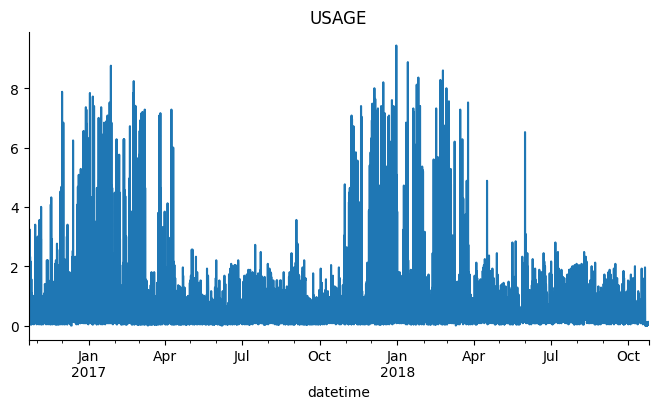

In [17]:
# Inspecting the usage over time

hourly_third_party['USAGE'].plot(kind='line', figsize=(8, 4), title='USAGE')
plt.gca().spines[['top', 'right']].set_visible(False)

There seems to be a trend of more energy usage in the winter. This makes sense given that it might be colder and that, hence, one might have to use the heater more.

In [18]:
#Adding a cost per kwh column
hourly_third_party["cost per kWh"] = hourly_third_party["COST"] / hourly_third_party["USAGE"]
hourly_third_party["cost per kWh"].replace([float("inf"), -float("inf")], pd.NA, inplace=True)
personal_reduced["cost per kWh"] = personal_reduced["COST"] / personal_reduced["USAGE"]
personal_reduced["cost per kWh"].replace([float("inf"), -float("inf")], pd.NA, inplace=True)

<ipython-input-18-76747a5e90cd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personal_reduced["cost per kWh"] = personal_reduced["COST"] / personal_reduced["USAGE"]
<ipython-input-18-76747a5e90cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personal_reduced["cost per kWh"].replace([float("inf"), -float("inf")], pd.NA, inplace=True)


In [19]:
personal_reduced["hour"] = personal_reduced.index.hour

#Group by the hour to find the average usage and cost per kWh for each hour across all days
personal_average_usage_per_hour = personal_reduced.groupby("hour")["USAGE"].mean()
personal_average_cost_per_kWh_per_hour = personal_reduced.groupby("hour")["cost per kWh"].mean()

hourly_third_party["hour"] = hourly_third_party.index.hour

#Group by the hour to find the average usage and cost per kWh for each hour across all days
third_average_usage_per_hour = hourly_third_party.groupby("hour")["USAGE"].mean()
third_average_cost_per_kWh_per_hour = hourly_third_party.groupby("hour")["cost per kWh"].mean()


<ipython-input-19-b9822195c4bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personal_reduced["hour"] = personal_reduced.index.hour


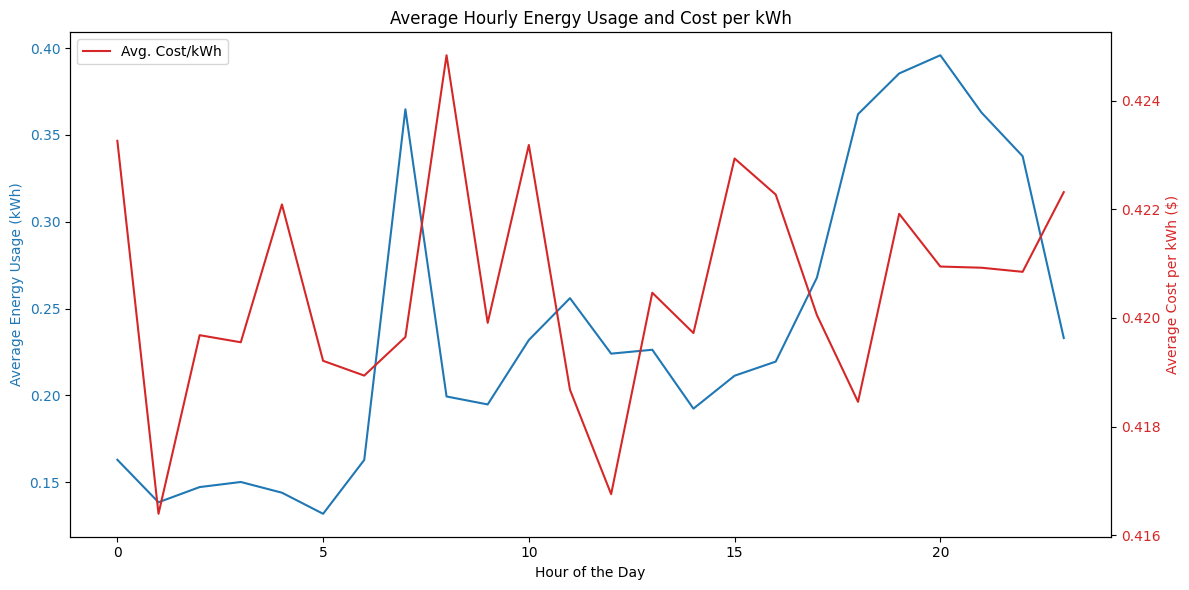

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 6))

#Plotting average energy usage
color = "tab:blue"
ax1.set_xlabel("Hour of the Day")
ax1.set_ylabel("Average Energy Usage (kWh)", color=color)
ax1.plot(personal_average_usage_per_hour.index, personal_average_usage_per_hour, color=color, label="Avg. Usage")
ax1.tick_params(axis='y', labelcolor=color)

#Create a second y-axis for the average cost per kWh
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Average Cost per kWh ($)", color=color)
ax2.plot(personal_average_cost_per_kWh_per_hour.index, personal_average_cost_per_kWh_per_hour, color=color, label="Avg. Cost/kWh")
ax2.tick_params(axis="y", labelcolor=color)
plt.title("Average Hourly Energy Usage and Cost per kWh")
plt.legend(loc="upper left")
fig.tight_layout()

plt.show()

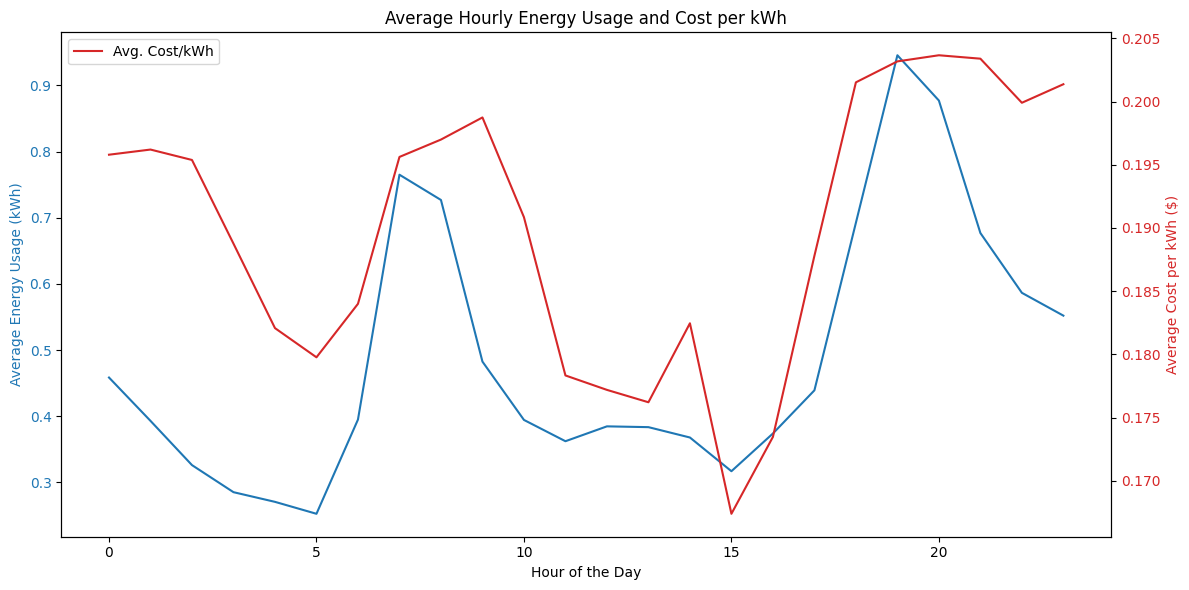

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 6))

#Plotting average energy usage
color = "tab:blue"
ax1.set_xlabel("Hour of the Day")
ax1.set_ylabel("Average Energy Usage (kWh)", color=color)
ax1.plot(third_average_usage_per_hour.index, third_average_usage_per_hour, color=color, label="Avg. Usage")
ax1.tick_params(axis='y', labelcolor=color)

#Create a second y-axis for the average cost per kWh
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Average Cost per kWh ($)", color=color)
ax2.plot(third_average_cost_per_kWh_per_hour.index, third_average_cost_per_kWh_per_hour, color=color, label="Avg. Cost/kWh")
ax2.tick_params(axis="y", labelcolor=color)
plt.title("Average Hourly Energy Usage and Cost per kWh")
plt.legend(loc="upper left")
fig.tight_layout()

plt.show()

Pricing appears pretty efficient as the two curves overlap for the most part for the third party. This is not the case for myself, most likely due to a small amount of data.

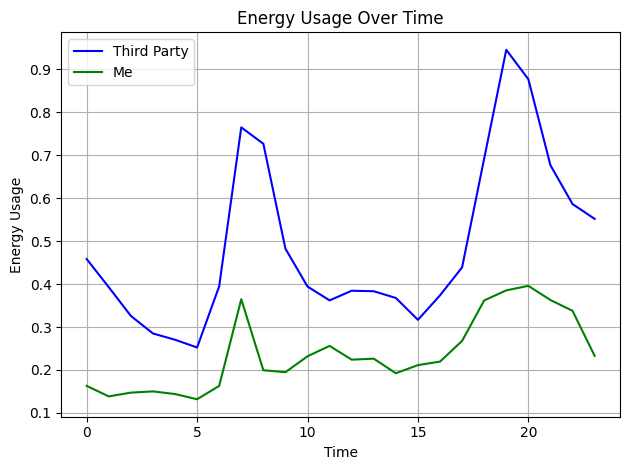

In [22]:
third_average_usage_per_hour.plot(label="Third Party", color="blue")
personal_average_usage_per_hour.plot(label="Me", color="green")

plt.title("Energy Usage Over Time")
plt.xlabel("Time")
plt.ylabel("Energy Usage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

There is a clear pattern by time of the day even among two different people. This is in align with the pricing as it shows that most people generally follow this pattern.

In [23]:
#Feature Engineering
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df["date"] = df.index
    df["hour"] = df["date"].dt.hour
    df["dayofweek"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["quarter"] = df["date"].dt.quarter
    df["dayofyear"] = df["date"].dt.dayofyear
    df["dayofmonth"] = df["date"].dt.day

    X = df[["hour", "dayofweek", "month", "dayofyear", 'quarter', "dayofmonth"]]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(hourly_third_party, label="USAGE")

features_and_target = pd.concat([X, y], axis=1)

In [24]:
features_and_target

,hour,dayofweek,month,dayofyear,quarter,dayofmonth,USAGE
datetime,,,,,,,
2016-10-22 00:00:00,0,5,10,296,4,22,0.04
2016-10-22 01:00:00,1,5,10,296,4,22,0.04
2016-10-22 02:00:00,2,5,10,296,4,22,0.08
2016-10-22 03:00:00,3,5,10,296,4,22,0.04
2016-10-22 04:00:00,4,5,10,296,4,22,0.04
...,...,...,...,...,...,...,...
2018-10-24 19:00:00,19,2,10,297,4,24,0.12
2018-10-24 20:00:00,20,2,10,297,4,24,0.12
2018-10-24 21:00:00,21,2,10,297,4,24,0.12


In [25]:
#Modeling to forecast energy usage

def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

y = features_and_target["USAGE"]
X = features_and_target[["hour", "dayofweek", "month", "dayofyear", 'quarter', "dayofmonth"]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.75, test_size=0.25)

In [26]:
# OLS
# create a model
lin_reg = LinearRegression(fit_intercept=True)

# fit the model
lin_model = lin_reg.fit(X_train, y_train)

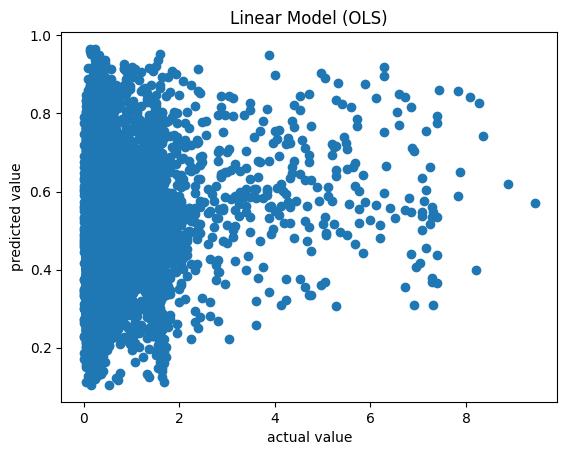

In [27]:

lin_pred = lin_model.predict(X_train)

plt.scatter(y_train, lin_pred)
plt.title('Linear Model (OLS)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

In [28]:
import statsmodels.api as sm


#add constant to predictor variables
x = sm.add_constant(X_train)

#fit linear regression model
model = sm.OLS(y_train, X_train).fit()

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  USAGE   R-squared (uncentered):                   0.265
Model:                            OLS   Adj. R-squared (uncentered):              0.265
Method:                 Least Squares   F-statistic:                              634.8
Date:                Fri, 05 Jul 2024   Prob (F-statistic):                        0.00
Time:                        19:12:44   Log-Likelihood:                         -12973.
No. Observations:               10554   AIC:                                  2.596e+04
Df Residuals:                   10548   BIC:                                  2.600e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

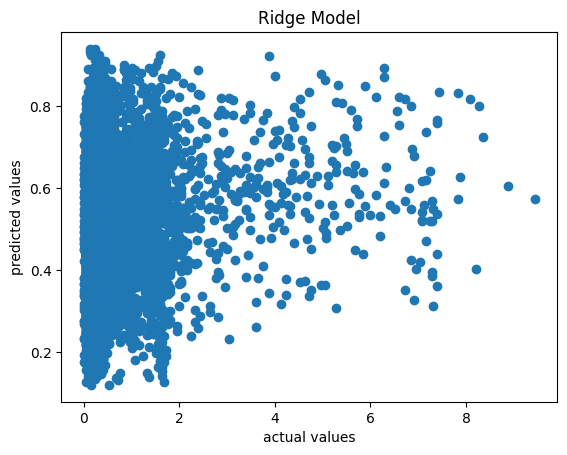

In [29]:
#Ridge
ridge_reg = Ridge(fit_intercept=True)
ridge_model = ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_train)
plt.scatter(y_train, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

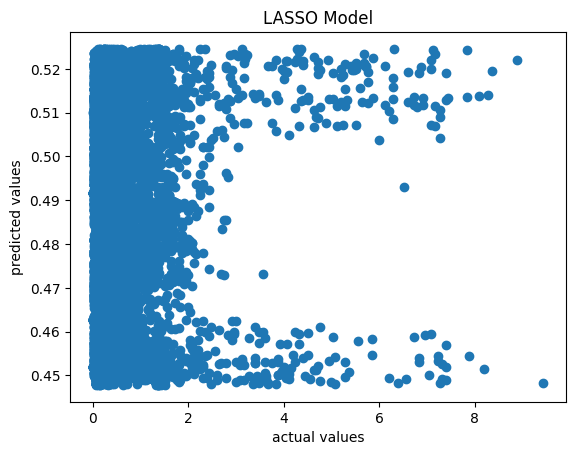

In [30]:
lasso_reg = Lasso(max_iter=10000, fit_intercept=True)

lasso_model = lasso_reg.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_train)
plt.scatter(y_train, lasso_pred)
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

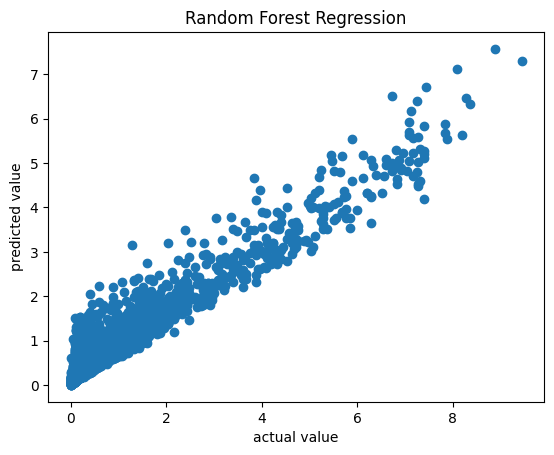

In [31]:
rmse(lasso_pred, y_train)
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=None)

rf_model = rf_reg.fit(X_train, y_train)

rf_pred = rf_model.predict(X_train)

plt.scatter(y_train, rf_pred)
plt.title('Random Forest Regression')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

By far the best prediction yet

In [32]:
#Tuning the Random Forest Model to make it more accurate

from sklearn.model_selection import GridSearchCV

param_grid = { 'n_estimators': [100, 200, 300],'max_depth': [5, 10, 20],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}

grid_search = GridSearchCV(rf_reg, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best score:  0.18765060983007872


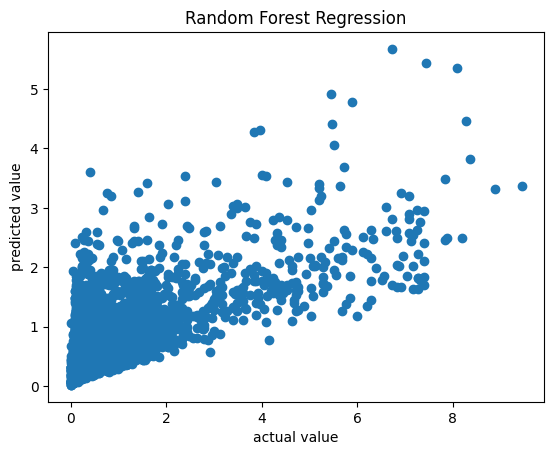

In [33]:
#Creating another Random Forest model with these hyperparameters

new_rf_reg = RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_split=2, min_samples_leaf=4)

new_rf_model = new_rf_reg.fit(X_train, y_train)

rf2_pred = new_rf_model.predict(X_train)

plt.scatter(y_train, rf2_pred)
plt.title('Random Forest Regression')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

In [34]:
lin_vpred = lin_model.predict(X_validate)
ridge_vpred = ridge_model.predict(X_validate)
lasso_vpred = lasso_model.predict(X_validate)
rf_vpred = rf_model.predict(X_validate)
rf_vpred_2 = new_rf_model.predict(X_validate)
print("linear model rmse: ", rmse(lin_vpred, y_validate))
print("Ridge rmse: ", rmse(ridge_vpred, y_validate))
print("LASSO rmse: ", rmse(lasso_vpred, y_validate))
print("Random Forest rmse: ", rmse(rf_vpred, y_validate))
print("Optimized Random Forest rmse: ", rmse(rf_vpred_2, y_validate))

linear model rmse:  0.8171501647648296
Ridge rmse:  0.8171812439367905
LASSO rmse:  0.8282698732494583
Random Forest rmse:  0.7824316232768986
Optimized Random Forest rmse:  0.7654146140496572


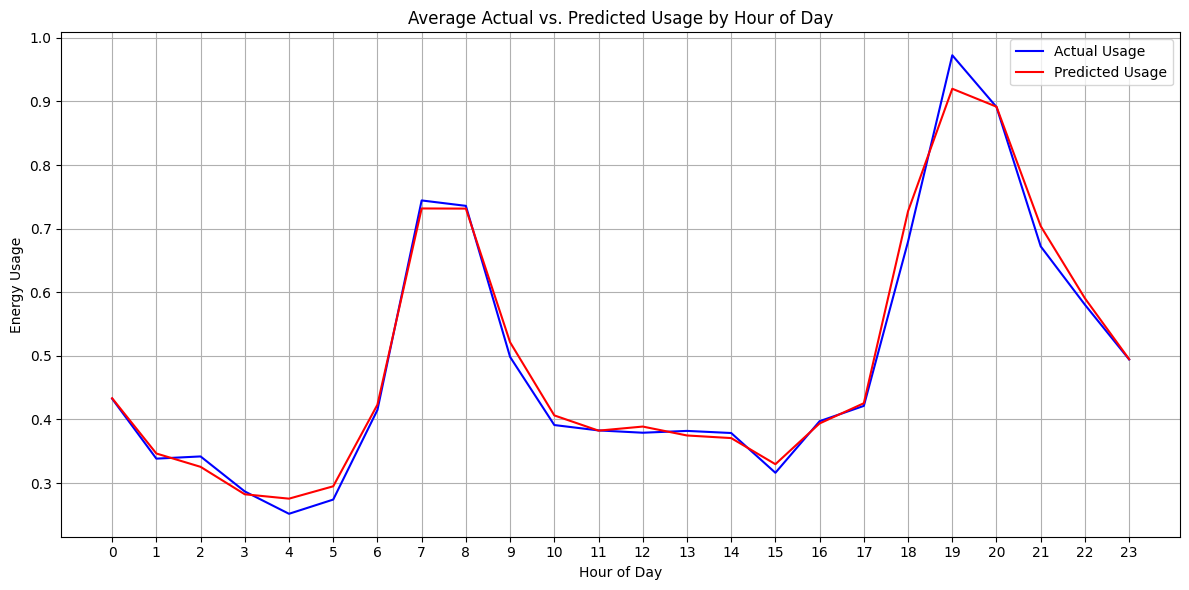

In [35]:
# Making a graph of predictions vs. actual values
X_train["hour"] = X_train.index.hour

comparison_df = pd.DataFrame({
    "Actual": y_train,
    "Predicted": rf2_pred
}, index=X_train.index)

grouped = comparison_df.groupby(X_train["hour"]).mean()

plt.figure(figsize=(12, 6))
plt.plot(grouped["Actual"], label="Actual Usage", color="blue")
plt.plot(grouped["Predicted"], label="Predicted Usage", color="red")
plt.title("Average Actual vs. Predicted Usage by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Energy Usage")
plt.xticks(grouped.index)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
#Moving into predicting price based on usage:
third_party_reduced["cost_per_kWh"] = third_party_reduced["COST"] / third_party_reduced["USAGE"]
hourly_data = third_party_reduced.resample("H").agg({
    "USAGE": 'sum',
    "cost_per_kWh": "mean"
})

#Remove 0 values

nan_summary = hourly_data.isna().sum()
print(nan_summary)

nan_percentage = hourly_data.isna().mean() * 100
print(nan_percentage)

hourly_data_removed = hourly_data.dropna()

USAGE            0
cost_per_kWh    70
dtype: int64
USAGE           0.000000
cost_per_kWh    0.397908
dtype: float64


<ipython-input-36-c037399e4e5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third_party_reduced["cost_per_kWh"] = third_party_reduced["COST"] / third_party_reduced["USAGE"]


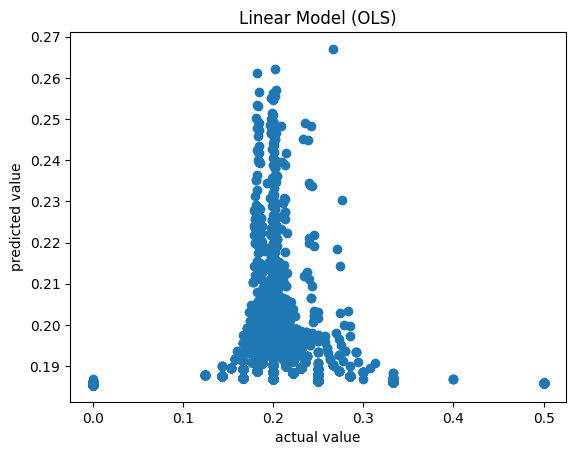

In [37]:
y = hourly_data_removed["cost_per_kWh"]
X = hourly_data_removed[["USAGE"]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.75, test_size=0.25)


# OLS
# create a model
lin_reg = LinearRegression(fit_intercept=True)

# fit the model
lin_model = lin_reg.fit(X_train, y_train)

lin_pred = lin_model.predict(X_train)

plt.scatter(y_train, lin_pred)
plt.title("Linear Model (OLS)")
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.show()

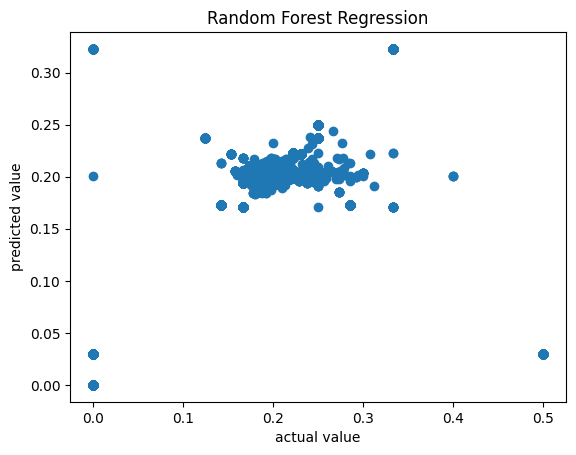

In [38]:
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=None)

rf_model = rf_reg.fit(X_train, y_train)

rf_pred = rf_model.predict(X_train)

plt.scatter(y_train, rf_pred)
plt.title("Random Forest Regression")
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.show()

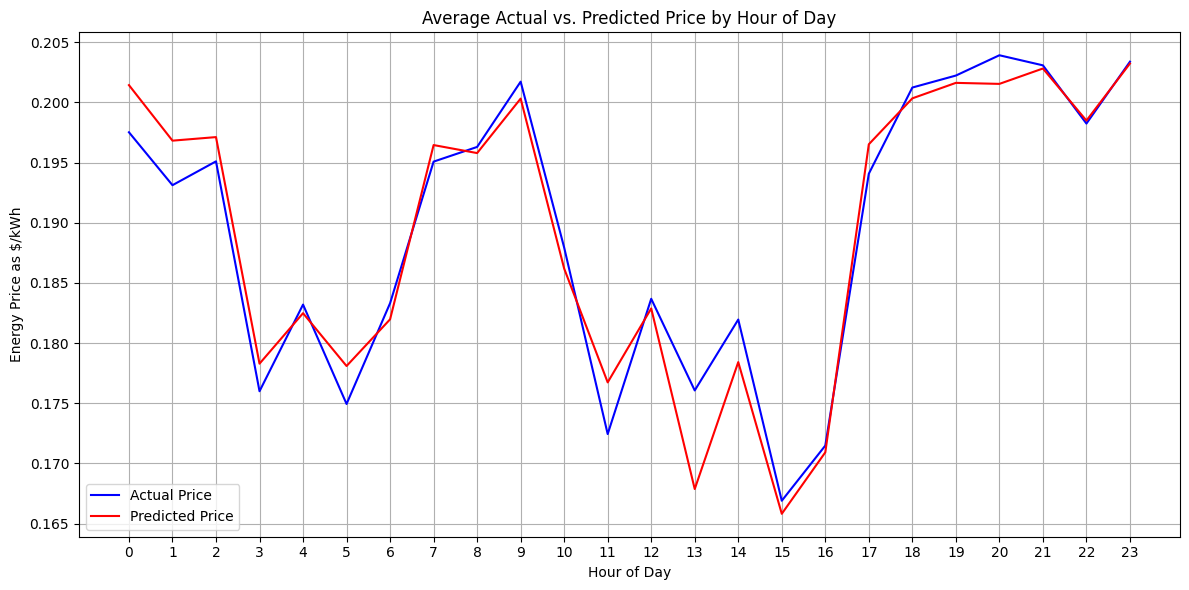

In [39]:

X_train["hour"] = X_train.index.hour

comparison_df = pd.DataFrame({
    "Actual": y_train,
    "Predicted": rf_pred
}, index=X_train.index)


grouped = comparison_df.groupby(X_train["hour"]).mean()
plt.figure(figsize=(12, 6))
plt.plot(grouped["Actual"], label="Actual Price", color="blue")
plt.plot(grouped["Predicted"], label="Predicted Price", color="red")
plt.title("Average Actual vs. Predicted Price by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Energy Price as $/kWh")
plt.xticks(grouped.index)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
#Next steps:
#Detect Anomalies to alert when energy is probably used inefficiently
#Energy efficiency
#Connect to weather and then automatically adjusted energy use based on weather


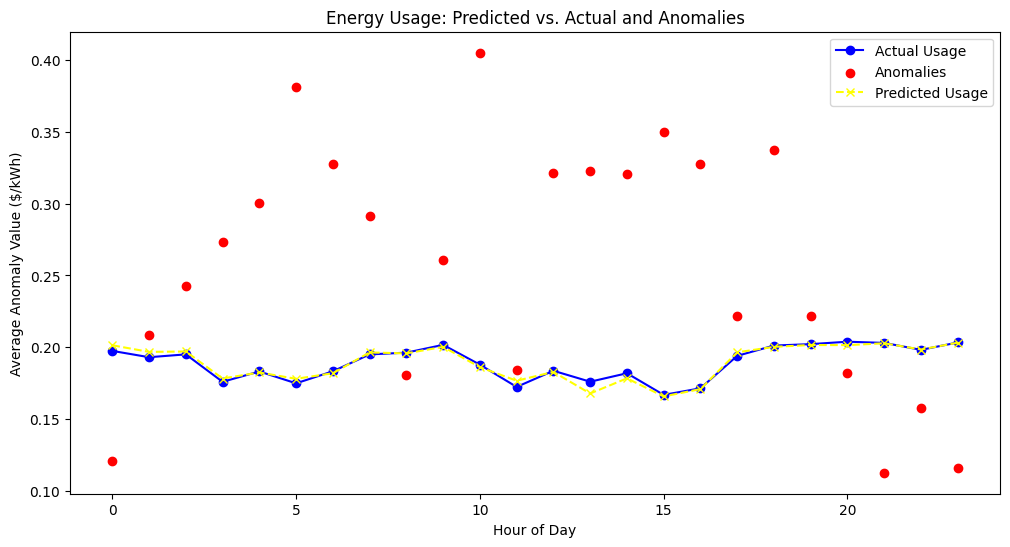

In [44]:
#Anomalies based on regression

# Calculate residuals
residuals = y_train - rf_pred

# Define a threshold for anomalies: here, mean +/- 2*std of residuals
std_dev = np.std(residuals)
mean_residual = np.mean(residuals)


anomalies = (residuals > mean_residual + 2 * std_dev)

anomalies_df = pd.DataFrame({
    'Anomalies': residuals[anomalies] # Store the actual residual values for anomalies
}, index=X_train[anomalies].index) # Use the corresponding datetime index

# Group by hour AFTER identifying anomalies to preserve the datetime index alignment
anomalies_hourly = anomalies_df.groupby(anomalies_df.index.hour).mean()

plt.figure(figsize=(12, 6))
plt.plot(grouped['Actual'], label='Actual Usage', marker='o', linestyle='-', color='blue')
# Use the grouped anomalies for plotting
plt.scatter(anomalies_hourly.index, anomalies_hourly['Anomalies'], color='red', label='Anomalies')
plt.plot(grouped['Predicted'], label='Predicted Usage', marker='x', linestyle='--', color='yellow')
plt.title('Energy Usage: Predicted vs. Actual and Anomalies')
plt.xlabel('Hour of Day') # Changed x-axis label to reflect grouping
plt.ylabel('Average Anomaly Value ($/kWh)') # Changed y-axis label to reflect anomaly value
plt.legend()
plt.show()